In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Part 01: Data preparation and feature engineering

In [2]:
df=pd.read_csv('Copy of Online Retail.csv',encoding='latin1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### 01) Clean the data

In [ ]:
# remove records with missing customer IDs
df = df.dropna(subset=['CustomerID'])

# filter for a single country to reduce complexity
df = df[df['Country'] == 'United Kingdom']

# remove cancelled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#### 02) Generate customer-level features

In [8]:
# Make sure 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reference date for recency (usually the last date in the dataset)
reference_date = df['InvoiceDate'].max()

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'Quantity': 'sum',                                          # We'll calculate monetary next
    'UnitPrice': 'mean'                                         # Needed for monetary
})

# Calculate Monetary value (total spending per customer)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['TotalPrice'].sum()

# Merge into RFM dataframe
rfm = rfm.drop(columns=['Quantity', 'UnitPrice'])
rfm['Monetary'] = monetary

# Rename columns properly
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency'}, inplace=True)

# Check RFM table
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12747.0           1         11   4196.01
12748.0           0        210  33719.73
12749.0           3          5   4090.88
12820.0           2          4    942.34


#### 03) Standaedize the RFM data before clustering

In [9]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming rfm dataframe from previous step
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the RFM features
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to a DataFrame for convenience
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Check the standardized data
print(rfm_scaled.head())


             Recency  Frequency   Monetary
CustomerID                                
12346.0     2.349480  -0.450546  10.068174
12747.0    -0.906268   0.937411   0.311738
12748.0    -0.916317  28.557767   4.258248
12749.0    -0.886171   0.104637   0.297685
12820.0    -0.896220  -0.034159  -0.123189


#### 04) Visualize the RFM distribution

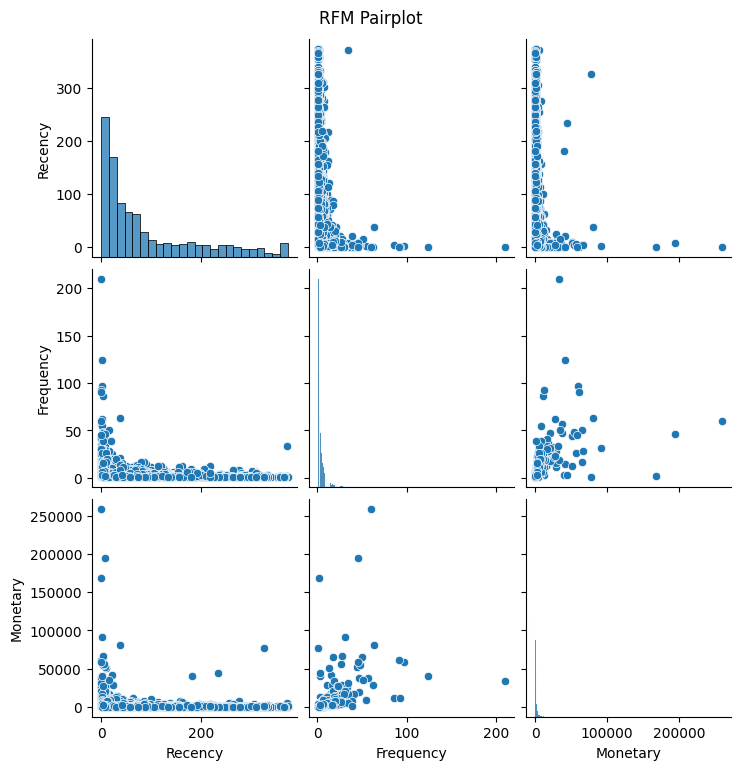

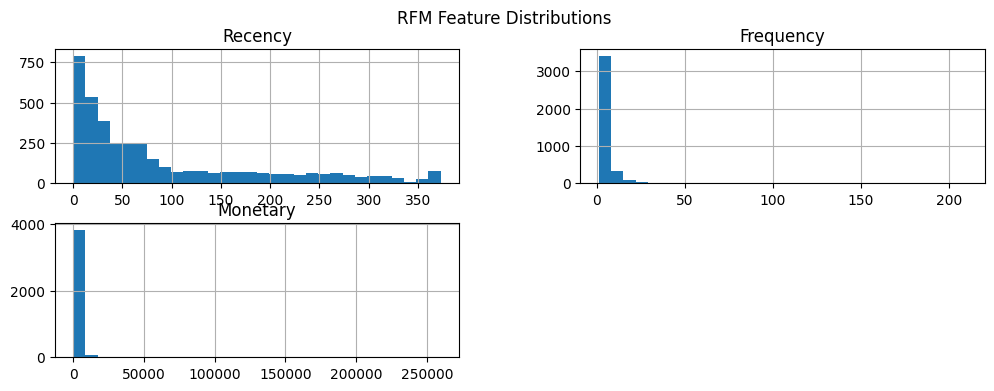

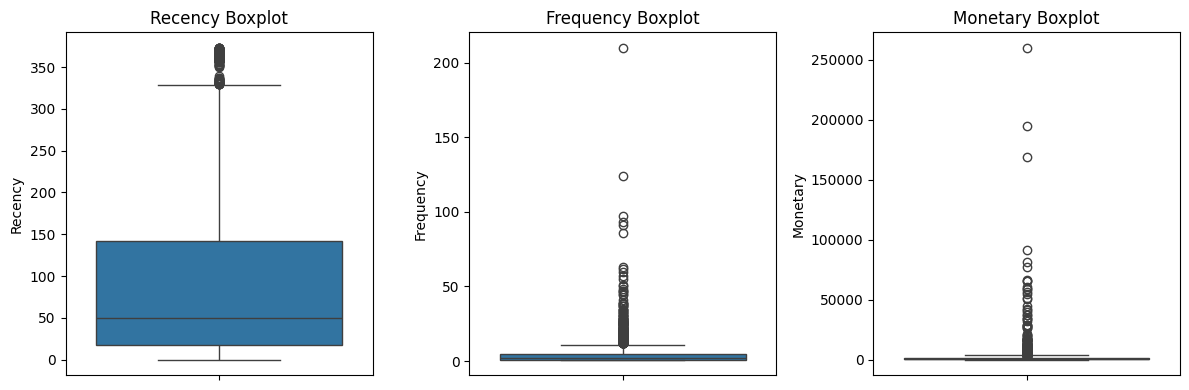

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rfm dataframe (original, not scaled)
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# 1. Pairplot to see relationships between features
sns.pairplot(rfm_features)
plt.suptitle('RFM Pairplot', y=1.02)
plt.show()

# 2. Histograms for each feature
rfm_features.hist(bins=30, figsize=(12, 4))
plt.suptitle('RFM Feature Distributions')
plt.show()

# 3. Optional: Boxplots to check for outliers
plt.figure(figsize=(12,4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=rfm_features[col])
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()


### Part 02: Apply and Analyze clustering methods

#### 2.1) K-Means clustering

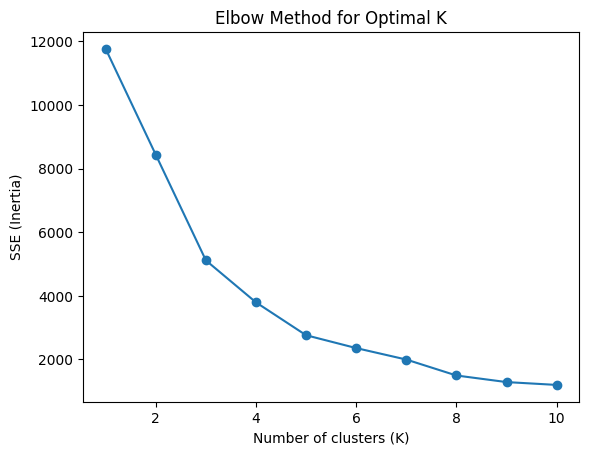

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal K
sse = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(K_range, sse, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()


In [12]:
# Suppose the elbow suggests K=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_scaled['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)

# Get centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])
print("Centroids (scaled RFM):")
print(centroids)


Centroids (scaled RFM):
    Recency  Frequency   Monetary
0  1.530183  -0.368250  -0.178663
1 -0.511584   0.025862  -0.036001
2 -0.803116   5.650802   4.041514
3 -0.892870   4.407305  27.495945


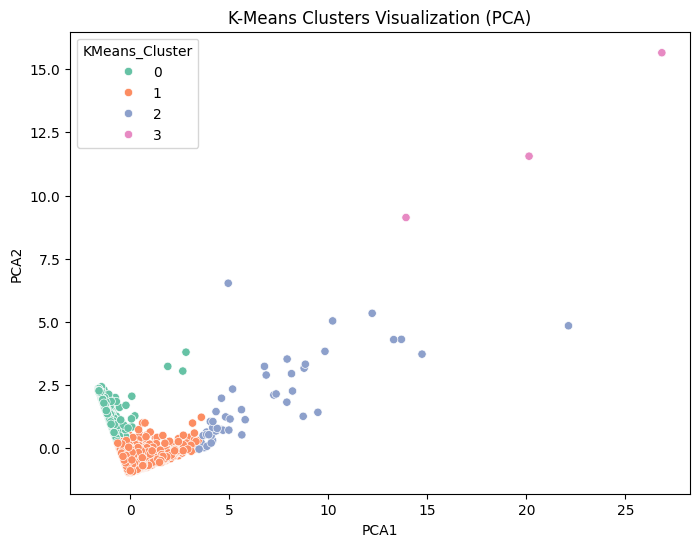

In [13]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
rfm_scaled['PCA1'] = rfm_pca[:,0]
rfm_scaled['PCA2'] = rfm_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_scaled, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set2')
plt.title('K-Means Clusters Visualization (PCA)')
plt.show()


#### 2.2) Hierarchical Clustering (AGNES)

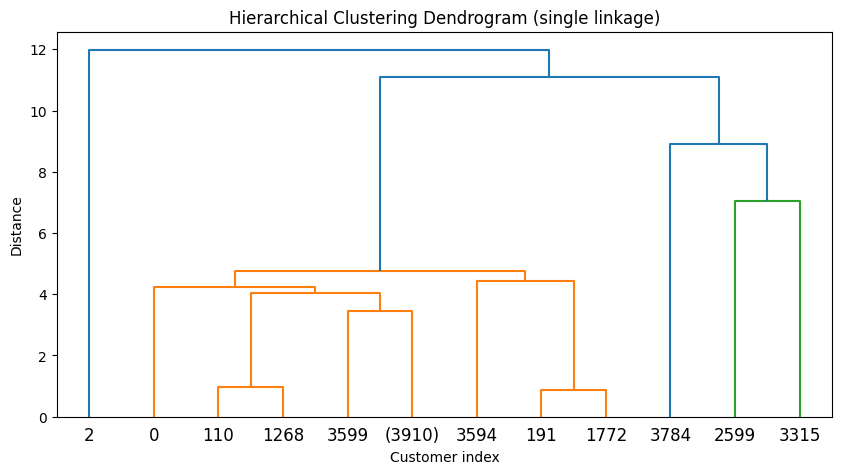

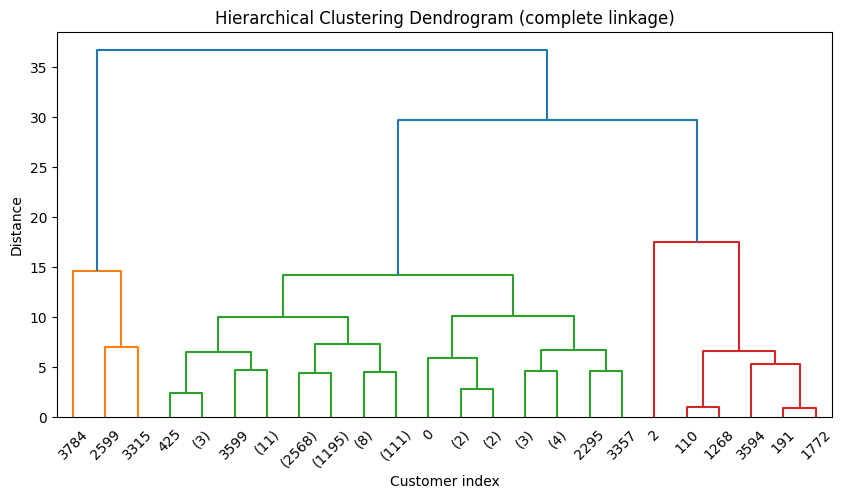

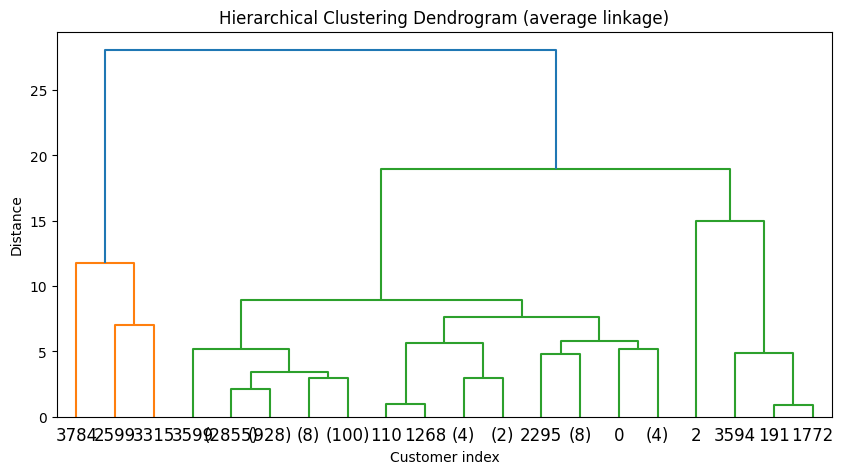

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkages = ['single', 'complete', 'average']
for link in linkages:
    plt.figure(figsize=(10, 5))
    Z = linkage(rfm_scaled[['Recency', 'Frequency', 'Monetary']], method=link)
    dendrogram(Z, truncate_mode='level', p=5)  # truncate for clarity
    plt.title(f'Hierarchical Clustering Dendrogram ({link} linkage)')
    plt.xlabel('Customer index')
    plt.ylabel('Distance')
    plt.show()


In [15]:
from scipy.cluster.hierarchy import fcluster

# Example: average linkage with 4 clusters
Z = linkage(rfm_scaled[['Recency', 'Frequency', 'Monetary']], method='average')
rfm_scaled['Hierarchical_Cluster'] = fcluster(Z, t=4, criterion='maxclust')


#### 2.3) DBSCAN 

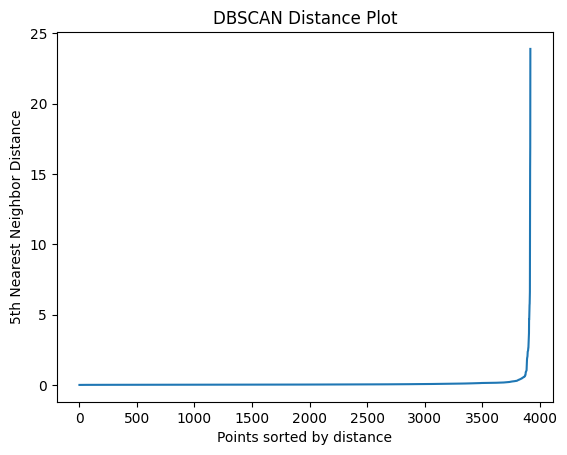

In [16]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
distances, indices = neighbors_fit.kneighbors(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
distances = np.sort(distances[:,4])  # 4th neighbor distance
plt.plot(distances)
plt.ylabel('5th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.title('DBSCAN Distance Plot')
plt.show()


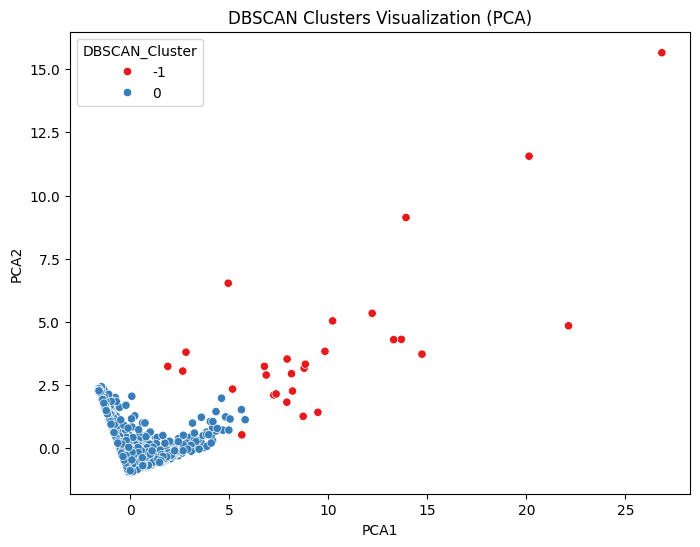

In [17]:
from sklearn.cluster import DBSCAN

# Example: eps=1.5, min_samples=5 (choose based on distance plot)
dbscan = DBSCAN(eps=1.5, min_samples=5)
rfm_scaled['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_scaled, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set1')
plt.title('DBSCAN Clusters Visualization (PCA)')
plt.show()


### Part 03: Clustering evaluation

#### 01) Silhouette Score

In [18]:
from sklearn.metrics import silhouette_score
import numpy as np

features = rfm_scaled[['Recency', 'Frequency', 'Monetary']]

# K-Means
kmeans_silhouette = silhouette_score(features, rfm_scaled['KMeans_Cluster'])
print("K-Means Silhouette Score:", kmeans_silhouette)

# Hierarchical
hier_silhouette = silhouette_score(features, rfm_scaled['Hierarchical_Cluster'])
print("Hierarchical Silhouette Score:", hier_silhouette)

# DBSCAN (exclude noise points -1)
mask = rfm_scaled['DBSCAN_Cluster'] != -1
dbscan_silhouette = silhouette_score(features[mask], rfm_scaled['DBSCAN_Cluster'][mask])
print("DBSCAN Silhouette Score:", dbscan_silhouette)


K-Means Silhouette Score: 0.5943564124538383
Hierarchical Silhouette Score: 0.9020722798073418


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

#### 02) Inter-cluster vs. intra-cluster Distance

In [19]:
from scipy.spatial.distance import cdist

def cluster_distances(features, labels):
    clusters = np.unique(labels)
    intra = []
    inter = []
    
    for c in clusters:
        if c == -1:  # skip noise in DBSCAN
            continue
        cluster_points = features[labels == c]
        centroid = cluster_points.mean(axis=0)
        intra.append(np.mean(cdist(cluster_points, [centroid])))  # avg distance to centroid
        
        # inter-cluster: distance to other centroids
        other_centroids = [features[labels == oc].mean(axis=0) for oc in clusters if oc != c and oc != -1]
        inter.append(np.mean([np.linalg.norm(centroid - oc) for oc in other_centroids]))
    
    return np.mean(intra), np.mean(inter)

# K-Means
kmeans_intra, kmeans_inter = cluster_distances(features.values, rfm_scaled['KMeans_Cluster'].values)
print("K-Means Intra:", kmeans_intra, "Inter:", kmeans_inter)

# Hierarchical
hier_intra, hier_inter = cluster_distances(features.values, rfm_scaled['Hierarchical_Cluster'].values)
print("Hierarchical Intra:", hier_intra, "Inter:", hier_inter)

# DBSCAN
dbscan_intra, dbscan_inter = cluster_distances(features[mask].values, rfm_scaled['DBSCAN_Cluster'][mask].values)
print("DBSCAN Intra:", dbscan_intra, "Inter:", dbscan_inter)


K-Means Intra: 2.7900729761707943 Inter: 16.051146397702304
Hierarchical Intra: 2.2214935827737294 Inter: 23.90806876991689
DBSCAN Intra: 1.0113932526146596 Inter: nan


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#### 03) Cluster Interpretation

In [20]:
# K-Means cluster profile
kmeans_profile = rfm.groupby(rfm_scaled['KMeans_Cluster']).agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'CustomerID':'count'
}).rename(columns={'CustomerID':'Num_Customers'})

print("K-Means Cluster Profiles:\n", kmeans_profile)


KeyError: "Column(s) ['CustomerID'] do not exist"